In [23]:
import tensorflow as tf
from loader import LoadedModel
from glob import glob
import numpy as np
from tqdm import tqdm
import os
import cv2
from typing import List
from imageio import imsave

import matplotlib.pyplot as plt
%matplotlib notebook

In [5]:
def prediction_fn(model_dir: str, input_dir: str, output_dir: str=None):

    if not output_dir:
        # For model_dir of style model_name/export/timestamp/ this will create a folder model_name/predictions'
        output_dir = '{}'.format(os.path.sep).join(model_dir.split(os.path.sep)[:-3] + ['predictions'])

    os.makedirs(output_dir, exist_ok=True)
    filenames_to_predict = glob(os.path.join(input_dir, '*.jpg'))
    # Load model
    with tf.Session():
        m = LoadedModel(model_dir, 'filename_original_shape')
        for filename in tqdm(filenames_to_predict, desc='Prediction'):
            pred = m.predict(filename)['probs'][0]
            np.save(os.path.join(output_dir, os.path.basename(filename).split('.')[0]), np.uint8(255 * pred))


In [25]:
def diva_post_processing_fn(probs: np.array, thresholds: List[float]=[0.5, 0.5, 0.5], min_cc: int=0,
                            page_mask: np.array=None, output_basename: str=None) -> np.ndarray:
    """
    :param probs: array in range [0, 1] of shape HxWx3
    :param thresholds: list of length 3 corresponding to the threshold for each channel
    :param min_cc: minimum size of connected components to keep
    :param border_removal: removes pixels in left and right border of the image that are within a certain margin
    :param output_basename:
    :return:
    """
    # border_margin = probs.shape[1] * 0.02
    final_mask = np.zeros_like(probs, dtype=np.uint8)
    # Compute binary mask for each class (each channel)

    if page_mask is not None:
        probs = (page_mask > 0)[:, :, None] * probs

    for ch in range(probs.shape[-1]):
        probs_ch = probs[:, :, ch]
        if thresholds[ch] < 0:  # Otsu thresholding
            probs_ch = np.uint8(probs_ch * 255)
            blur = cv2.GaussianBlur(probs_ch, (5, 5), 0)
            thresh_val, bin_img = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            bin_img = bin_img / 255
        else:
            bin_img = probs_ch > thresholds[ch]

        if min_cc > 0:
            _, labeled_cc = cv2.connectedComponents(bin_img.astype(np.uint8), connectivity=8)
            for lab in np.unique(labeled_cc):
                mask = labeled_cc == lab
                if np.sum(mask) < min_cc:
                    labeled_cc[mask] = 0
            final_mask[:, :, ch] = bin_img * (labeled_cc > 0)
        else:
            final_mask[:, :, ch] = bin_img

    result = final_mask.astype(int)

    if output_basename is not None:
        imsave('{}.png'.format(output_basename), result*255)

    return result

In [8]:
model_dirs_list = ['../../dataset/model2/export/1562877546/']
input_dir = '../../dataset/cb55/val/images/'
output_dir_name = 'out_predictions'

In [9]:
for model_dir in model_dirs_list:
    output_dir = '{}'.format(os.path.sep).join(model_dir.split(os.path.sep)[:-3] + [output_dir_name])
    os.makedirs(output_dir, exist_ok=True)
    prediction_fn(model_dir, input_dir, output_dir)

Loading ../../dataset/model2/export/1562877546/
INFO:tensorflow:Restoring parameters from ../../dataset/model2/export/1562877546/variables/variables


Prediction: 100%|██████████| 10/10 [00:14<00:00,  1.26s/it]


In [43]:
probs = np.load(os.path.join(output_dir,'e-codices_fmb-cb-0055_0129v_max.npy'))

<IPython.core.display.Javascript object>


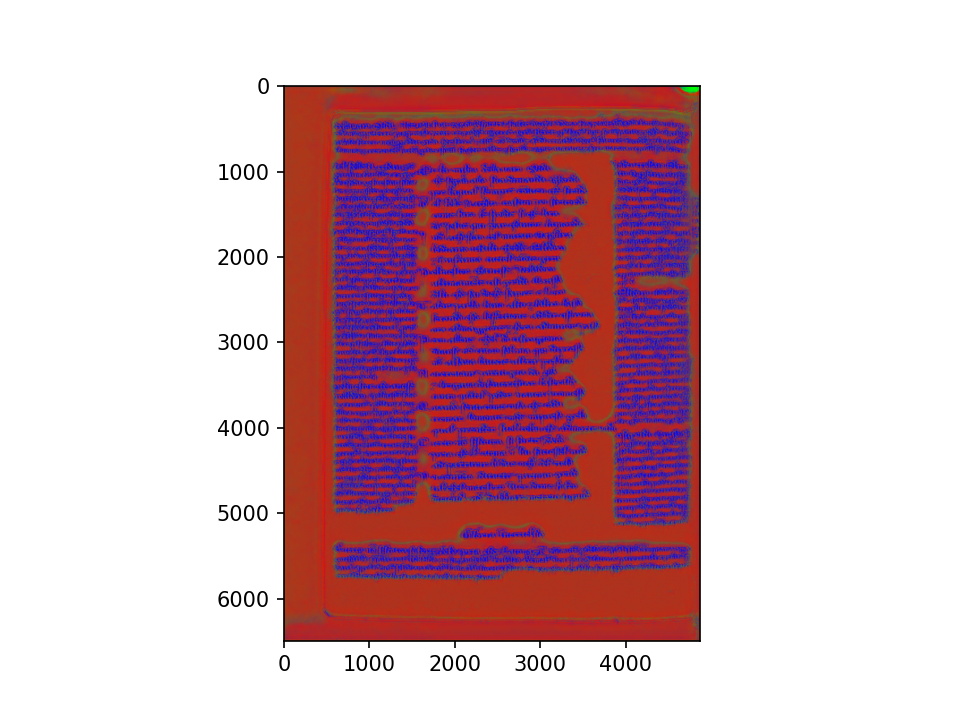

In [44]:
plt.figure()
plt.imshow(probs)
plt.show()

In [41]:
result = diva_post_processing_fn(probs/np.max(probs))

<IPython.core.display.Javascript object>


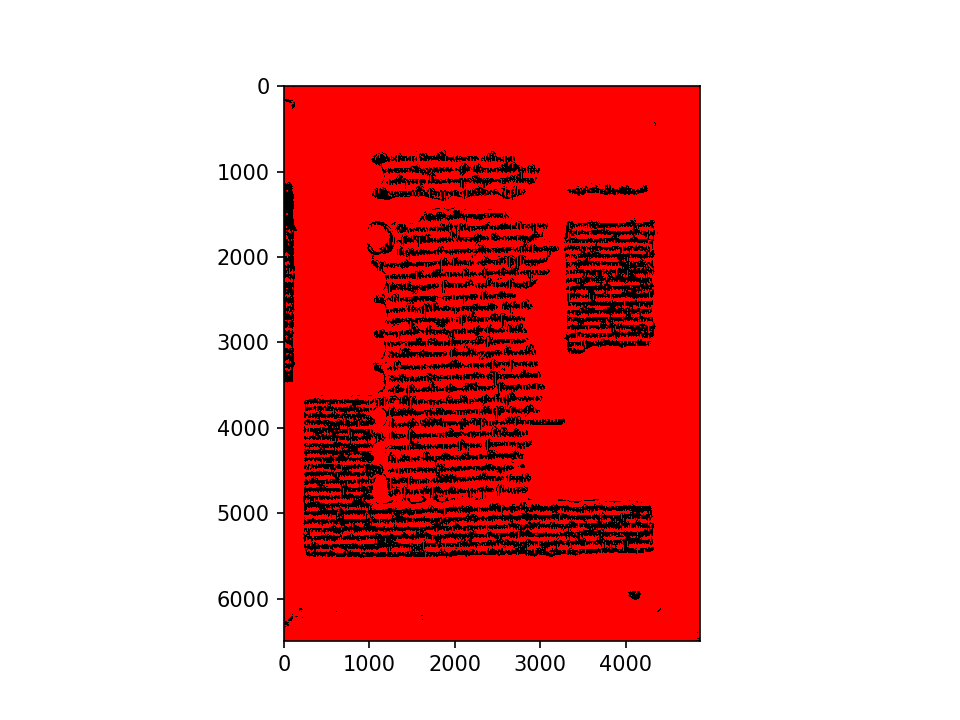

<IPython.core.display.Javascript object>


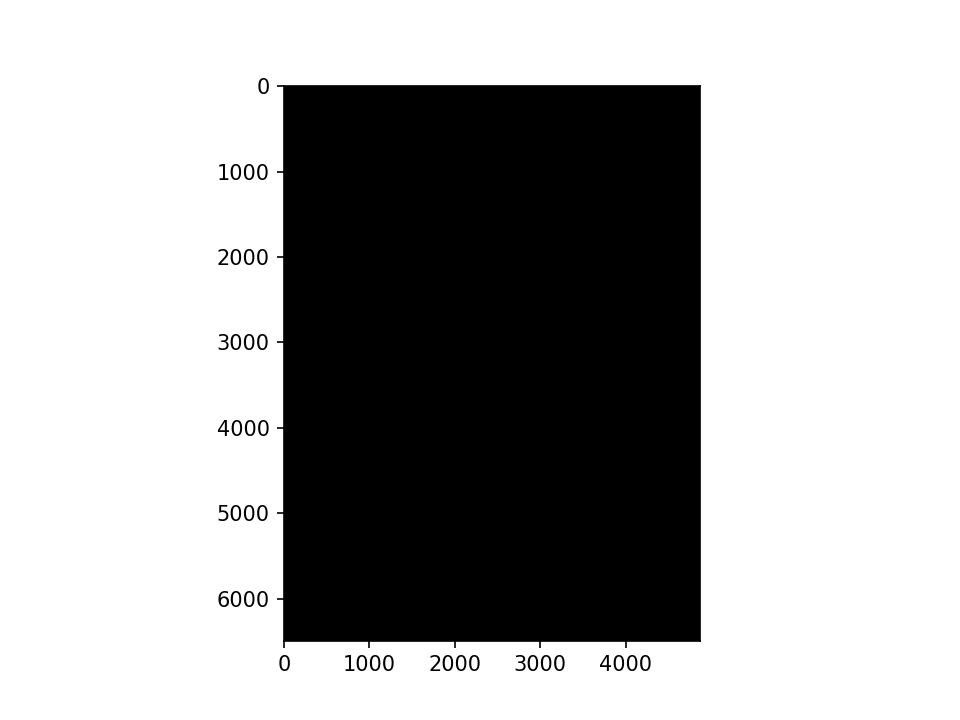

<IPython.core.display.Javascript object>


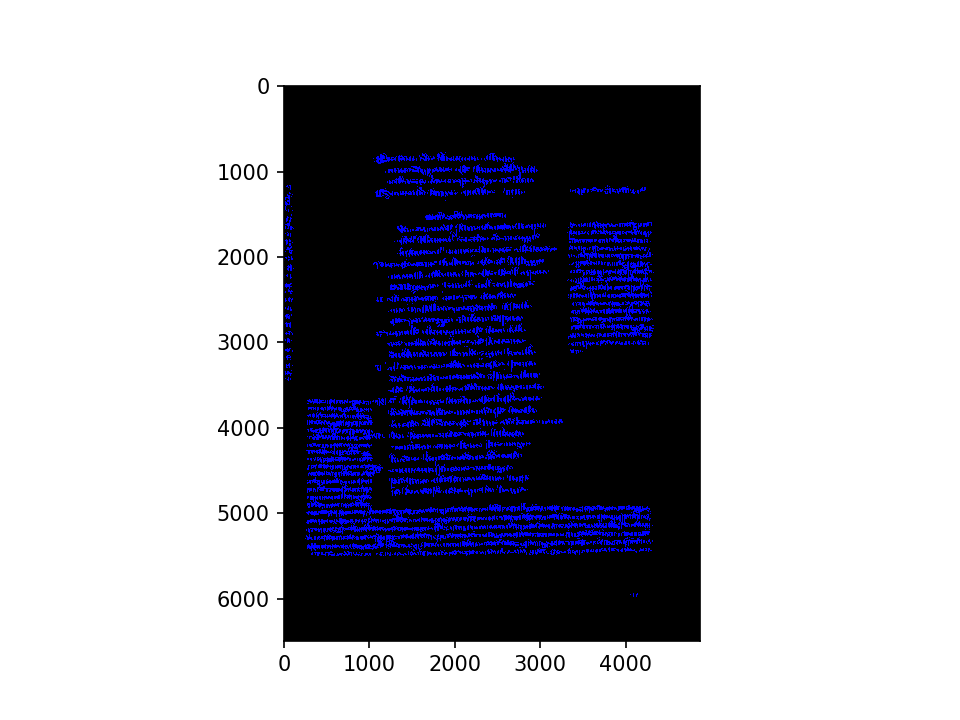

In [45]:
mask_1 = np.copy(result)*0
mask_2 = np.copy(result)*0
mask_3 = np.copy(result)*0

mask_1[:,:,0] = 1
mask_2[:,:,1] = 1
mask_3[:,:,2] = 1

plt.figure()
plt.imshow(mask_1*result*255)
plt.show()
plt.figure()
plt.imshow(mask_2*result*255)
plt.show()
plt.figure()
plt.imshow(mask_3*result*255)
plt.show()